# Grokking LIME: How can we explain why an image classifier "knows" what’s in a photo without looking inside the model?

Kilian Kluge, [Inlinity](https://www.inlinity.ai) & [XAI Studio](https://www.xai-studio.de)

[https://github.com/ionicsolutions/grokking-lime](https://github.com/ionicsolutions/grokking-lime)


- GitHub: [ionicsolutions](https://github.com/ionicsolutions)
- Twitter: [@kilian_kluge](https://www.twitter.com/kilian_kluge)

<div style="width: 100%; margin-bottom: 100px;">
    <div><a href="https://www.inlinity.ai"><img src="assets/inlinity_logo_electric_blue.png" style="height:60px; margin-bottom: 30px;" /></a></div><div>
    <a href="https://www.xai-studio.de"><img src="assets/xai-studio-logo-m.png" style="height:60px;" /></a></div>
</div>

## Explainable AI? XAI? Interpretable Machine Learning?

<img src="assets/opaque_interpretable.png" width="500"/>

<img src="assets/explainable.png" width="500" />
<div style="height: 230px;" />

## NIST's Four Principles of XAI
![NIST's Four Principles of XAI](assets/four_principles.png)
<div style="height: 200px;" />

## Preparations

In [1]:
# Essentials

import numpy as np
from PIL import Image

In [2]:
# Visualization aids

import pandas as pd
from skimage.segmentation import mark_boundaries

def show_image(array: np.ndarray) -> Image:
    return Image.fromarray(np.uint8(array))

def show_segments(image: np.ndarray, segment_mask: np.ndarray) -> Image:
    return show_image(255 * mark_boundaries(image, segment_mask))

<div style="height: 200px;" />

## Load an image

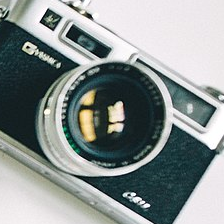

In [3]:
full_image = Image.open("camera.png")
full_image

In [4]:
image = np.array(full_image)
image.shape

(224, 224, 3)

In [5]:
image[15,77,0]

246

<div style="height: 200px;" />

## Load an image classification model

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2, preprocess_input, decode_predictions
)

In [7]:
model = MobileNetV2()

2022-04-09 12:17:17.987229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model_prediction = model.predict(preprocess_input(image[None,:,:,:]))
model_prediction.shape

(1, 1000)

In [9]:
model_prediction[0,:10]

array([7.8035788e-05, 5.7162320e-05, 2.3809653e-05, 5.8984726e-05,
       1.9584166e-05, 2.5267385e-05, 6.5439999e-05, 2.0421536e-04,
       9.7909896e-04, 1.9297648e-04], dtype=float32)

In [10]:
np.argmax(model_prediction[0])

759

In [11]:
decode_predictions(model_prediction)

[[('n04069434', 'reflex_camera', 0.46481198),
  ('n02988304', 'CD_player', 0.0989774),
  ('n02978881', 'cassette', 0.07376168),
  ('n03692522', 'loupe', 0.0485741),
  ('n02992529', 'cellular_telephone', 0.046890922)]]

<img src="assets/opaque.png" width="600" />

## LIME: Local Interpretable Model-Agnostic Explanations

Ribeiro et al. (2016): ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938)


1. [Segment the image](#Step-1:-Segment-the-image)
2. [Generate samples](#Step-2:-Generate-samples)
3. [Generate images](#Step-3:-Generate-images)
4. [Predict images](#Step-4:-Predict-images)
5. [Fit linear model](#Step-5:-Fit-linear-model)
6. [Generate visual explanation](#Step-6:-Generate-visual-explanation)

<div style="height: 200px;" />

## Step 1: Segment the image

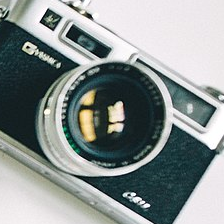

In [12]:
full_image

In [13]:
from skimage.segmentation import felzenszwalb

In [14]:
## live-code
segment_mask = felzenszwalb(image, scale=300)

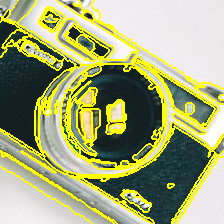

In [15]:
## live-code
show_segments(image, segment_mask)

In [16]:
## live-code
segment_mask.shape

(224, 224)

In [17]:
## live-code
segment_mask

array([[ 0,  0,  0, ...,  5,  5,  5],
       [ 0,  0,  0, ...,  5,  5,  5],
       [ 0,  0,  0, ...,  5,  5,  5],
       ...,
       [84, 84, 84, ..., 81, 81, 81],
       [84, 84, 84, ..., 81, 81, 81],
       [84, 84, 84, ..., 81, 81, 81]])

In [18]:
print("Number of segments:", np.max(segment_mask) + 1)

Number of segments: 94


<div style="height: 300px;" />

## Step 2: Generate samples

In [19]:
def generate_samples(segment_mask: np.ndarray, num_of_samples: int) -> np.ndarray:
    ## live-code
    num_of_segments = np.max(segment_mask) + 1

    samples = np.random.rand(num_of_samples, num_of_segments) > 0.4
    
    ## /live-code
    return samples.astype(int)

In [20]:
samples = generate_samples(segment_mask, 128)
samples.shape

(128, 94)

In [21]:
## live-code
pd.DataFrame(samples).head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0,1,1,0,1,1,1,0,1,1,...,1,1,1,0,0,0,1,0,1,1
1,1,1,0,1,1,0,1,1,0,0,...,1,0,1,1,1,0,1,1,1,1
2,0,1,0,0,0,0,1,1,1,0,...,0,1,1,1,1,0,0,0,0,1
3,0,0,1,1,0,0,1,1,1,0,...,1,0,1,1,1,0,1,1,1,1
4,1,1,0,1,0,1,1,1,0,1,...,1,0,0,1,0,0,0,1,1,1


<div style="height: 300px;" />

## Step 3: Generate images

In [22]:
def generate_images(image: np.ndarray,
                    segment_mask: np.ndarray,
                    samples: np.ndarray) -> np.ndarray:
    ## live-code
    images = []
    
    for sample in samples:
        
        mask = np.zeros(shape=segment_mask.shape, dtype=int)
        
        for segment_id in np.unique(segment_mask):
            
            if sample[segment_id] == 1:
                
                mask[segment_mask == segment_id] = 1
        
        images.append(mask[:, :, None] * image)
        
    
    return np.array(images)

In [23]:
images = generate_images(image, segment_mask, samples)
images.shape

(128, 224, 224, 3)

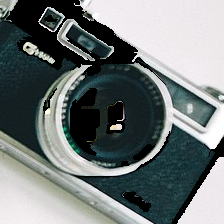

In [24]:
## live-code
show_image(images[18])

<div style="height: 300px;" />

## Step 4: Predict images

In [25]:
## live-code
predictions = model.predict(preprocess_input(images))

2022-04-09 12:17:21.221205: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.
2022-04-09 12:17:21.252155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 156905472 exceeds 10% of free system memory.
2022-04-09 12:17:21.557478: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.
2022-04-09 12:17:21.585965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 156905472 exceeds 10% of free system memory.
2022-04-09 12:17:21.908882: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 154140672 exceeds 10% of free system memory.


In [26]:
predictions.shape

(128, 1000)

<div style="height: 300px;" />

## Step 5: Fit linear model

In [27]:
from sklearn.linear_model import BayesianRidge
linear_model = BayesianRidge()

In [28]:
pd.DataFrame(samples).head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0,1,1,0,1,1,1,0,1,1,...,1,1,1,0,0,0,1,0,1,1
1,1,1,0,1,1,0,1,1,0,0,...,1,0,1,1,1,0,1,1,1,1
2,0,1,0,0,0,0,1,1,1,0,...,0,1,1,1,1,0,0,0,0,1
3,0,0,1,1,0,0,1,1,1,0,...,1,0,1,1,1,0,1,1,1,1
4,1,1,0,1,0,1,1,1,0,1,...,1,0,0,1,0,0,0,1,1,1


In [29]:
distances = np.linalg.norm(samples, axis=1)

In [30]:
## live-code
linear_model.fit(samples, predictions[:, 759], sample_weight=distances)

BayesianRidge()

In [31]:
linear_model.coef_.shape

(94,)

In [32]:
linear_model.coef_[:10]

array([-0.01276775,  0.02077101,  0.01766419, -0.01198122,  0.04387899,
        0.01349309,  0.0049721 ,  0.0078564 ,  0.00749642,  0.0068955 ])

<div style="height: 300px;" />

## Step 6: Generate visual explanation

In [33]:
from visualime.explain import render_explanation

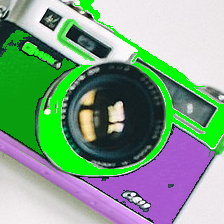

In [34]:
render_explanation(image,
                   segment_mask,
                   linear_model.coef_,
                   positive="green",
                   negative="violet")

<div style="height: 300px;" />

## Links & further reading

- This talk/notebook:
  - [github.com/ionicsolutions/grokking-lime](https://github.com/ionicsolutions/grokking-lime)
- Papers:
  - Phillips et al. (2021): [Four Principles of Explainable AI](https://nvlpubs.nist.gov/nistpubs/ir/2021/NIST.IR.8312.pdf) (NIST)
  - Ribeiro et al. (2016): ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938)
- LIME implementations:
  - [Original LIME on GitHub](https://github.com/marcotcr/lime) & [on PyPI](https://pypi.org/project/lime/)
  - [VisuaLIME on GitHub](https://github.com/xai-demonstrator/visualime) & [on PyPI](https://pypi.org/project/visualime/)